In [1]:
import os
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import get_window

import IPython.display as ipd

In [2]:
from utils.MyPlots import amp_time_graphic, freq_1D_graphic

## **Understanding dataset** 

In [3]:
folder_path = os.path.join("data","raw")
file_path   = os.path.join(folder_path, "OSR_us_000_0010_8k.wav")

sr, x = wav.read(file_path)

ipd.Audio(data=x,rate=sr)

<details>

<summary>Dataset description</summary>
    
| File | Label |
| :-: | :-: | 
| OSR_us_000_0010_8k.wav | F|
| OSR_us_000_0011_8k.wav | F|
| OSR_us_000_0012_8k.wav | F|
| OSR_us_000_0013_8k.wav | F|
| OSR_us_000_0014_8k.wav | F|
| OSR_us_000_0015_8k.wav | F|
| OSR_us_000_0016_8k.wav | F|
| OSR_us_000_0017_8k.wav | F|
| OSR_us_000_0018_8k.wav | F|
| OSR_us_000_0019_8k.wav | F|
| OSR_us_000_0030_8k.wav | M|
| OSR_us_000_0031_8k.wav | M|
| OSR_us_000_0032_8k.wav | M|
| OSR_us_000_0034_8k.wav | M|
| OSR_us_000_0035_8k.wav | M|
| OSR_us_000_0036_8k.wav | M|
| OSR_us_000_0037_8k.wav | M|
| OSR_us_000_0038_8k.wav | M|
| OSR_us_000_0039_8k.wav | M|
| OSR_us_000_0040_8k.wav | M|
| OSR_us_000_0057_8k.wav | M|
| OSR_us_000_0059_8k.wav | M|
| OSR_us_000_0060_8k.wav | M|
| OSR_us_000_0061_8k.wav | M|

</details>

In [4]:
Ts = 1/sr
Tf = len(x)/sr

t = np.arange(0, Tf, Ts)

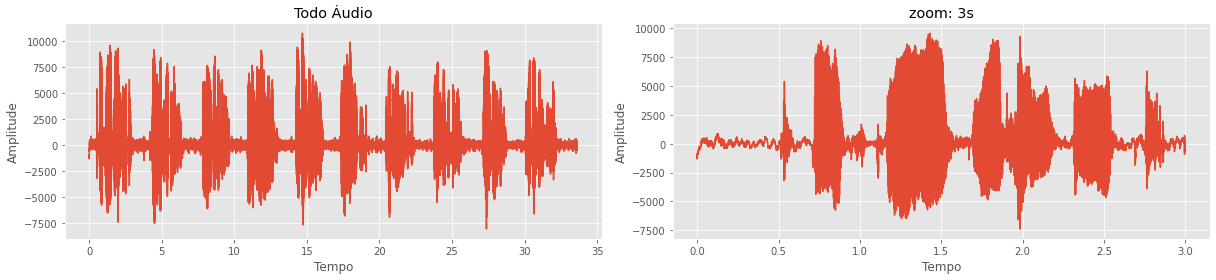

In [5]:
fig, axs = plt.subplots(1,2, figsize=(17,4))

texts = ["Tempo", "Amplitude"]

amp_time_graphic(t, x, 
                 axs[0], *(texts + [None,"Todo Áudio"]))

seconds = 3
qtd_n = int(seconds*sr)
amp_time_graphic(t[:qtd_n], x[:qtd_n], 
                 axs[1], *(texts + [None,f"zoom: {seconds}s"]))

plt.tight_layout()
plt.show()

Vamos trabalhar inicialmente com uma parte do áudio.

In [6]:
x = x[:qtd_n]
t = t[:qtd_n]

## **Preprocessing**

Esse passo amplifica as frequências mais altas. A ideia é balancearmos as magnitudes do espectro das frequências, pois altas frequências geralmente tem menor amplitude.

$$
y[t] = x[t] - \alpha x[t-1]
$$

<center><img src="figures/emph_audio.png" style="width: 200px;"/></center>

Obs: Neste caso $t$ começa em 1. Logo $y$ tem uma posição a menos que $x$. Por isso temos que $x[0] = y[0]$.

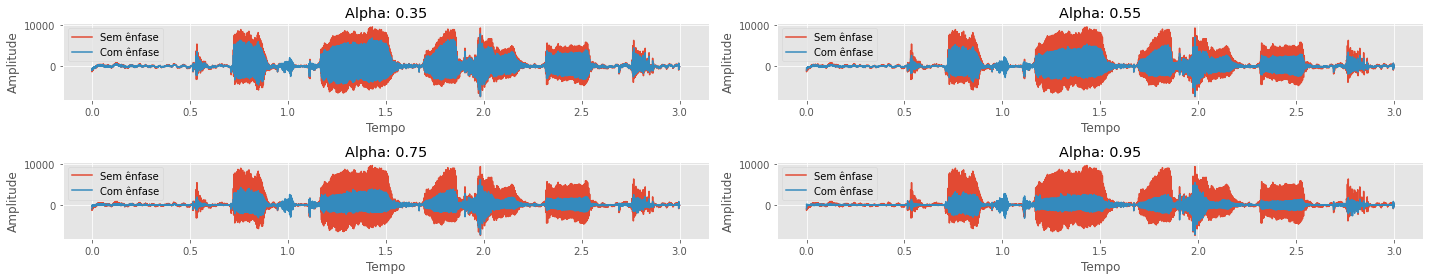

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(20,4))

for ax, i in zip(axs.flatten(), range(4)):

    texts = ["Tempo", "Amplitude"]
    
    alpha = 0.35 + i*0.2
    #x[0] é adicionado para termos o mesmo tamanho de sinal.
    emph_x = np.append(x[0], x[1:] - alpha*x[:-1])

    texts_sem = texts + ["Sem ênfase", f"Alpha: {round(alpha,2)}"]
    texts_com = texts + ["Com ênfase", f"Alpha: {round(alpha,2)}"]

    amp_time_graphic(t, x,      ax, *texts_sem)
    amp_time_graphic(t, emph_x, ax, *texts_com)
    ax.legend()

plt.tight_layout()
plt.show()

Antes:

In [8]:
ipd.Audio(data=x,rate=sr)

Depois com $\alpha = 0.95$ :

In [9]:
ipd.Audio(data=emph_x,rate=sr)

## **Doings Frames**



Vamos usar: 
- $framesize = 25ms$
- $stride = 10ms$

Logo temos $15ms$ de $overlap$ (25 - 10). Normalmente, em processamento de áudio, usa-se frames de tamanho entre 20ms a 40ms com 40% a 60% de overlap entre frames consecutivos. 

In [10]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = int(frame_size*sr),int(frame_stride*sr) 

N = len(emph_x)

qtd_frames = int(np.ceil((N - frame_length)/frame_step))

In [11]:
print(f"Quantidade de samples do sinal: {N}")
print(f"Tamanho do frame: {frame_length}")
print(f"Tamanho do passo: {frame_step}")

Quantidade de samples do sinal: 24000
Tamanho do frame: 200
Tamanho do passo: 80


Zero padding último frame:

In [12]:
tot_size = frame_length + frame_step*qtd_frames
zero_pad = tot_size - N

pad_x = np.pad(emph_x, (0,zero_pad), 'constant', constant_values=0)

In [13]:
print(f"Qtd necessaria de samples: {tot_size}")
print(f"Qtd samples sinal: {N}")
print(f"Qtd zero pad: {zero_pad}")

Qtd necessaria de samples: 24040
Qtd samples sinal: 24000
Qtd zero pad: 40


In [14]:
#w para janelas
w = np.tile(np.arange(0,frame_length), (qtd_frames,1))

#d para deslocamentos
d = np.tile(np.arange(0, qtd_frames*frame_step, frame_step).reshape(-1,1), (1,frame_length))

idxs = w+d

In [15]:
frames = pad_x[idxs]

In [16]:
print("Quantidade de frames: %d\nTamanho do frame: %d" % frames.shape)

Quantidade de frames: 298
Tamanho do frame: 200


## **Applying window**

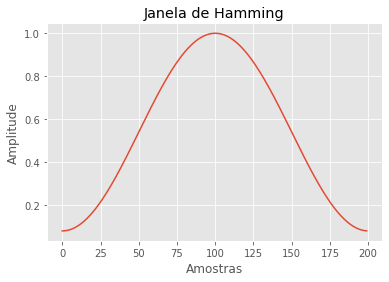

In [17]:
hanning = get_window("hamming", frame_length)
plt.plot(hanning)
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.title("Janela de Hamming")
plt.show()

In [18]:
#Usando reshape para reforçar entendimento da direção do broadcasting
frames_w = frames * hanning.reshape(1,-1)

## **Applying FFT** 

Caso NFFT seja um número par a função ```np.fft.rfft``` retorna $(\frac{n}{2}) + 1$. Além disso, realiza zero padding caso a janela seja menor que NFFT.

https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html#numpy.fft.rfft

Para encontrar as frequências em Hz podemos utilizar a seguinte equação:

$$\frac{Sample Rate * k}{NFFT}$$

Obs: Já implementado no numpy: ```np.fft.rfftfreq```.

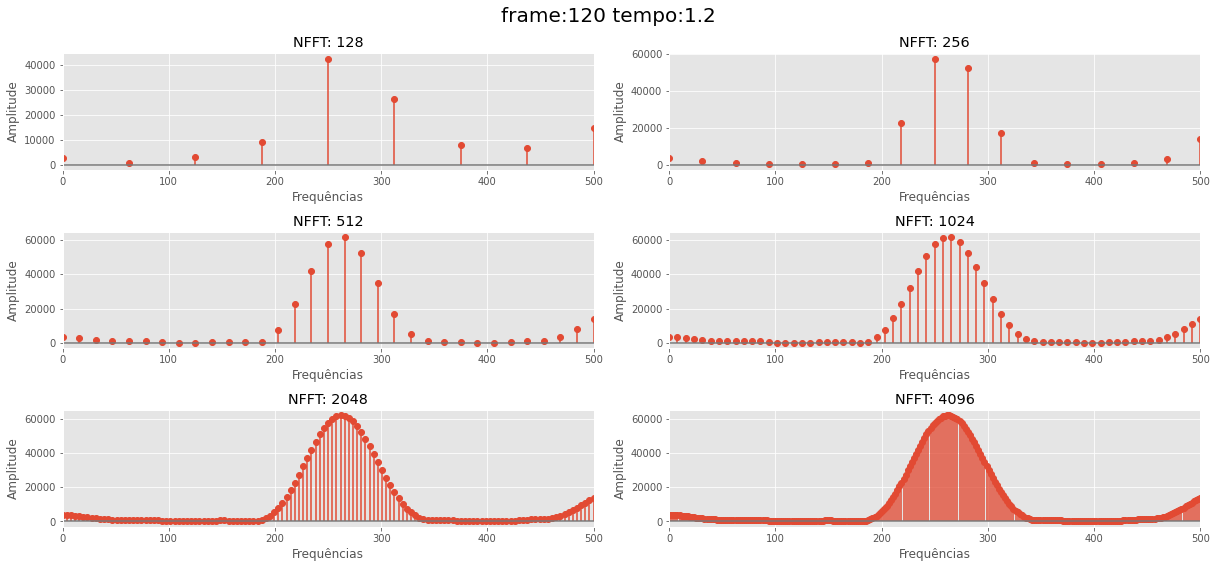

In [32]:
frame_num = 120

fig, axs = plt.subplots(3,2,figsize = (17,8))

plt.suptitle(f"frame:{frame_num} tempo:{frame_num*frame_stride}",fontsize=20)

for ax, p in zip(axs.flatten(),range(7,13)):
    #Uma potência de 2 (mais eficiente) maior que o tamanho do frame.
    NFFT = 2**p 
    #Realiza zero padding caso o número NFFT for maior que o frame.
    X = np.absolute(np.fft.rfft(frames_w, NFFT)) 
    #Calcula as frequências em Hz baseado no k, sample rate e NFFT.
    freqs = np.fft.rfftfreq(NFFT, 1/sr)

    text = ["Frequências", "Amplitude", None, f"NFFT: {NFFT}"]
    freq_1D_graphic(freqs, X[frame_num,:], ax, *text)
    
plt.tight_layout() 
plt.show()

Vamos utilizar $NFFT = 512$:

In [20]:
NFFT = 512
#Realiza zero padding caso o número NFFT for maior que o frame.
X = np.absolute(np.fft.rfft(frames_w, NFFT)) 
#Calcula as frequências em Hz baseado no k, sample rate e NFFT.
freqs = np.fft.rfftfreq(NFFT, 1/sr)

In [21]:
qtd_freq = X.shape[1]
print(r"Frames: %d Frequências (ks): %d" % X.shape)

Frames: 298 Frequências (ks): 257


### **Espectograma** 

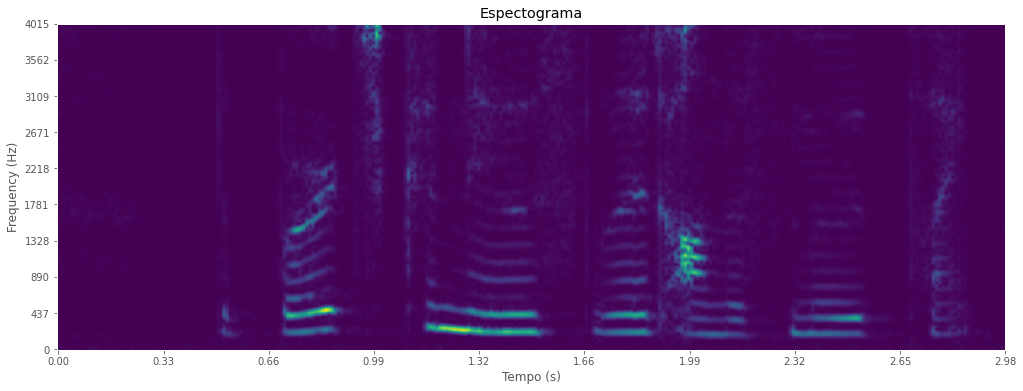

In [22]:
fig=plt.figure(figsize=(17,6))
plt.imshow(X.transpose(), origin="lower", aspect='auto')

plt.title("Espectograma")
plt.xlabel("Frames")
plt.ylabel("Frequências")

## create ylim
Nyticks = 10
ks      = np.linspace(0, qtd_freq, Nyticks)
ksHz    = [int(sr*int(i)/NFFT) for i in ks]
plt.yticks(ks,ksHz)
plt.ylabel("Frequency (Hz)")

## create xlim
Nxticks = 10
ts_spec = np.linspace(0, qtd_frames, Nxticks)
ts_spec_sec  = ["{:4.2f}".format(i*frame_stride) for i in ts_spec]
plt.xticks(ts_spec,ts_spec_sec)
plt.xlabel("Tempo (s)")

#plt.yticks()
plt.grid()
plt.show()

> Existe um trade-off entre resolução de frequência e tempo, isto é, se queremos uma melhor resolução temporal precisamos abrir mão da resolução no domínio da frequência. 

### **Periodograma** 

$$P = \frac{|FFT(x_i)|^2}{N}$$

In [23]:
perio = (1/NFFT) * X**2

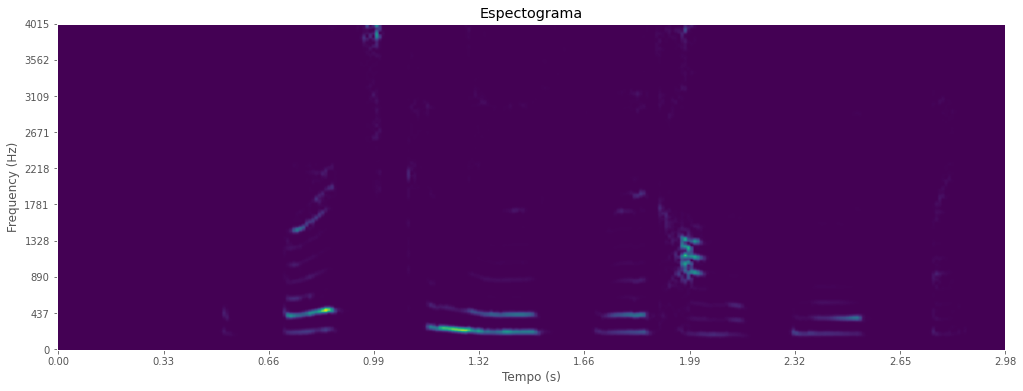

In [24]:
fig=plt.figure(figsize=(17,6))
plt.imshow(perio.transpose(), origin="lower", aspect='auto')

plt.title("Espectograma")
plt.xlabel("Frames")
plt.ylabel("Frequências")

## create ylim
Nyticks = 10
ks      = np.linspace(0, qtd_freq, Nyticks)
ksHz    = [int(sr*int(i)/NFFT) for i in ks]
plt.yticks(ks,ksHz)
plt.ylabel("Frequency (Hz)")

## create xlim
Nxticks = 10
ts_spec = np.linspace(0, qtd_frames, Nxticks)
ts_spec_sec  = ["{:4.2f}".format(i*frame_stride) for i in ts_spec]
plt.xticks(ts_spec,ts_spec_sec)
plt.xlabel("Tempo (s)")

#plt.yticks()
plt.grid()
plt.show()

## **Mel Spectrogram** 

### **Compute Bank Filter** 

A escala Mel tenta se assemelhar a percepção não linear do ouvido humano, discriminando melhor baixas frequências e discriminando pior altas frequências. Podemos converter entre as escalas utilizando as seguintes equações:

$$
m = 2595\log_{10}(1+\frac{f}{700})
$$

$$
f = 700(10^{\frac{m}{2595}}-1)
$$

In [25]:
mel2Hz = lambda f: 2595*np.log10(1+f/700)
hz2Mel = lambda m: 700*(10**(m/2595)-1)
hz2K = lambda f: np.floor((NFFT+1)*f/sr)

In [26]:
num_filt  = 40
low_mel   = mel2Hz(freqs[0])
high_mel  = mel2Hz(freqs[-1])
mi        = np.linspace(low_mel, high_mel, num_filt+2)
hzms = np.array(list(map(hz2Mel, mi)))
kms  = np.array(list(map(hz2K, hzms)),dtype=np.int32)

In [27]:
fbank = np.zeros([num_filt, qtd_freq])
#Equação da reta para a subida
rise    = lambda fst, mid,  k: (k-fst)/(mid-fst)
#Equação da reta para a descida
descent = lambda mid, last, k: (last-k)/(last-mid)

    
for fst, mid, last, idx in zip(kms[0:], kms[1:], kms[2:],range(num_filt)):

    rise_values    = np.array(list(map(lambda k: rise(fst, mid,  k), np.arange(fst,mid))))
    descent_values = np.array(list(map(lambda k: descent(mid, last, k), np.arange(mid,last))))

    fbank[idx, fst:mid] = rise_values
    fbank[idx, mid:last] = descent_values

In [28]:
filter_banks = np.dot(perio, fbank.T)
filter_banks = np.where(filter_banks==0, np.finfo(float).eps, filter_banks)
filter_banks = 20*np.log10(filter_banks)

### **Plotting Mel Scale** 

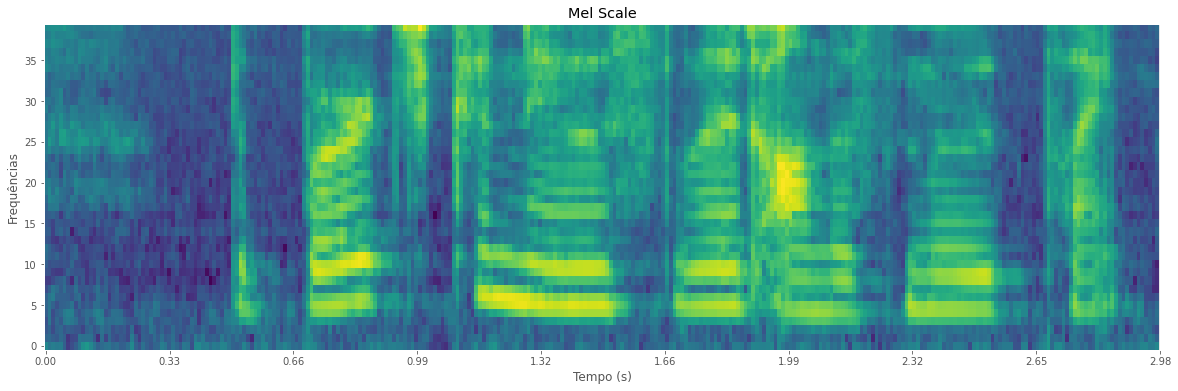

In [29]:
fig=plt.figure(figsize=(20,6))
plt.imshow(filter_banks.transpose(), origin="lower", aspect='auto')

plt.title("Mel Scale")
plt.xlabel("Frames")
plt.ylabel("Frequências")

## create xlim
Nxticks = 10
ts_spec = np.linspace(0, qtd_frames, Nxticks)
ts_spec_sec  = ["{:4.2f}".format(i*frame_stride) for i in ts_spec]
plt.xticks(ts_spec,ts_spec_sec)
plt.xlabel("Tempo (s)")

#plt.yticks()
plt.grid()
plt.show()